In [88]:
import pandas as pd
import numpy as np
from pyswarm import pso
from shapely import Point, LineString
import geopandas as gpd
import matplotlib.pyplot as plt

In [89]:
data_path = '1m_precision_staiLine_11.csv'
swath_path = '../Scratch/test_Load_Shp/test_shps/swath_group_1.shp'
raw_data = pd.read_csv(data_path)
real_swath = gpd.read_file(swath_path)

In [90]:
# 处理 raw_data
# raw_data['height'] = raw_data['height'].apply(ast.literal_eval)
# raw_data['aspect'] = raw_data['aspect'].apply(ast.literal_eval)
# raw_data['slope'] = raw_data['slope'].apply(ast.literal_eval)
data_array = raw_data.to_numpy()
data_array

array([[4.40345934e+05, 4.39753270e+06, 2.05810000e+04, 9.83658800e+01,
        7.34330800e+00, 0.00000000e+00],
       [4.40346431e+05, 4.39753183e+06, 2.05490000e+04, 1.06429300e+02,
        5.80420500e+00, 0.00000000e+00],
       [4.40346927e+05, 4.39753096e+06, 2.05490000e+04, 1.06429300e+02,
        5.80420500e+00, 0.00000000e+00],
       ...,
       [4.40429747e+05, 4.39741294e+06, 2.00110000e+04, 6.61612600e+01,
        3.36302140e+00, 2.70000000e+01],
       [4.40430243e+05, 4.39741207e+06, 1.99900000e+04, 8.87811300e+01,
        5.03731440e+00, 2.70000000e+01],
       [4.40430740e+05, 4.39741121e+06, 1.99900000e+04, 8.87811300e+01,
        5.03731440e+00, 2.70000000e+01]])

In [91]:
# 测试随机取出 
random_sample = np.random.choice(data_array.shape[0], 20, replace=False)
random_sample = data_array[random_sample]
random_sample

array([[4.40358683e+05, 4.39756039e+06, 2.03410000e+04, 7.65859000e+01,
        8.73039200e+00, 2.00000000e+01],
       [4.40403695e+05, 4.39743928e+06, 2.01570000e+04, 7.66397800e+01,
        5.86834670e+00, 3.00000000e+00],
       [4.40377386e+05, 4.39749625e+06, 2.02520000e+04, 5.40747570e+01,
        7.34450400e+00, 7.00000000e+00],
       [4.40386314e+05, 4.39747728e+06, 2.02480000e+04, 9.00000000e+01,
        4.21792750e+00, 6.00000000e+00],
       [4.40411880e+05, 4.39744420e+06, 2.00840000e+04, 7.82317100e+01,
        3.50717140e+00, 2.70000000e+01],
       [4.40383449e+05, 4.39746957e+06, 2.02860000e+04, 7.33007600e+01,
        3.73336670e+00, 1.00000000e+00],
       [4.40414214e+05, 4.39742581e+06, 2.01090000e+04, 8.33333400e+01,
        2.77396100e+00, 5.00000000e+00],
       [4.40378596e+05, 4.39749757e+06, 2.02190000e+04, 3.97187580e+01,
        6.02982430e+00, 9.00000000e+00],
       [4.40360829e+05, 4.39750666e+06, 2.04040000e+04, 8.83634300e+01,
        3.75617960e+00, 

In [97]:
def fitness_function(lambdas, origin_x, origin_y, height, aspect, slope, labels):
    # 将 aspect 转换为 弧度值
    aspect = np.deg2rad(aspect)
    x_off = lambdas[0] * np.cos(aspect) * slope
    y_off = lambdas[1] * np.cos(aspect) * slope
    
    new_x = origin_x + x_off
    new_y = origin_y + y_off
    
    # optimize
    distances = []
    for temp_x, temp_y, label in zip(new_x, new_y, labels):
        temp_point = Point(temp_x, temp_y)
        temp_real_swath = real_swath.geometry.iloc[label]
        distances.append(temp_point.distance(temp_real_swath))
    return np.mean(distances)

In [99]:
lower_bound, upper_bound = [-1, -1], [1, 1]
results = []
EPOCH = 2
SAMPLE_BATCH=200

for i in range(EPOCH):
    print('---------------Epoch: {}---------------'.format(i))
    # random choice sample data
    random_sample = np.random.choice(data_array.shape[0], SAMPLE_BATCH, replace=True)
    random_sample = data_array[random_sample]
    # read data from random sample
    batch_origin_x = random_sample[:, 0]
    batch_origin_y = random_sample[:, 1]
    batch_height = random_sample[:, 2]
    batch_aspect = random_sample[:, 3]
    batch_slope = random_sample[:, 4]
    batch_labels = random_sample[:, 5].astype(np.int32)
    
    args = (batch_origin_x, batch_origin_y, batch_height, batch_aspect, batch_slope, batch_labels)
    xopt, fopt = pso(fitness_function, lower_bound, upper_bound, args=args)
    # showing temp result
    print('Optimized offs: ', xopt)
    print('Fopt: ', fopt)
    results.append((xopt, fopt))

---------------Epoch: 0---------------
Stopping search: Swarm best objective change less than 1e-08
Optimized offs:  [-0.08525666  0.14042479]
Fopt:  0.40352814607014514
---------------Epoch: 1---------------
Stopping search: Swarm best objective change less than 1e-08
Optimized offs:  [-0.00977994 -0.00414468]
Fopt:  0.3729750182225022


In [100]:
new_results = np.array(results)
new_results

/var/folders/r2/bv03lgdn7y58thlc1ntrzgvc0000gn/T/ipykernel_9853/590953463.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_results = np.array(results)


array([[array([-0.08525666,  0.14042479]), 0.40352814607014514],
       [array([-0.00977994, -0.00414468]), 0.3729750182225022]],
      dtype=object)

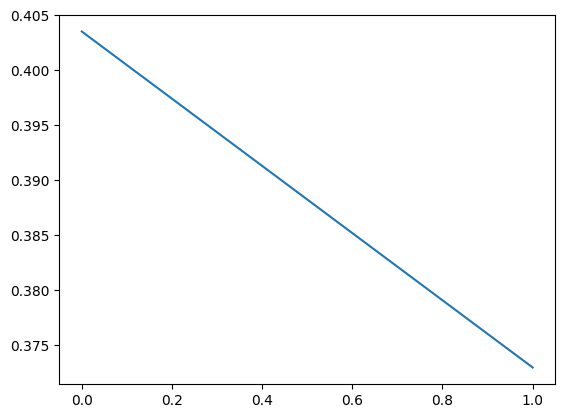

In [101]:
plt.plot(new_results[:, 1])

(array([-0.00977994, -0.00414468]), 0.3729750182225022)